In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace
from ord2017 import ORD2017

In [7]:
'''
O'Hara-Rudy CiPA v1.0 (2017)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
end_time = 500
bcl = 1000
duration = 0.5
offset = 20

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 5000)  

simulation_library = 'scipy'

In [8]:
import simulator_myokit
import simulator_scipy
'''
Simulation with Myokit
'''
start_time = time.time()

if simulation_library == 'myokit':
    model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017.mmt" )
    protocol = myokit.pacing.blocktrain(bcl, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0
    sim = simulator_myokit.Simulator(model, protocol, max_step=1.0, abs_tol=1e-08, rel_tol=1e-10, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10
    sim.name = "ORD2017"
    sim.bcl = bcl
    
elif simulation_library == 'scipy' :
    protocol = protocol_lib.PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')
    model = ORD2017(protocol, is_exp_artefact=False)
    sim = simulator_scipy.Simulator(model)
    
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.0051500797271728516 seconds ---


In [9]:
start_time = time.time()

sol = {}
if simulation_library == 'myokit':    
    sim.simulation.set_constant('cell.mode', cells['Epicardial'])    
    y0 = sim.pre_simulate(bcl*100, sim_type=1)
    d = sim.simulate(end_time, log_times=None, extra_log=['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL', 'ik1.IK1', 'inal.INaL'])
    
    times = d['engine.time']
    sol["Voltage"] = d['membrane.V']
    sol["I_Na"] = d['ina.INa']
    sol["I_Kr"] = d['ikr.IKr']
    sol["I_Ks"] = d['iks.IKs']
    sol["I_To"] = d['ito.Ito']
    sol["I_CaL"] = d['ical.ICaL']
    sol["I_K1"] = d['ik1.IK1']
    sol["I_NaL"] = d['inal.INaL']
         
elif simulation_library == 'scipy':
    sim.model.change_cell(cells['Epicardial'])    
    # model.y0[0] = -88
    sim.pre_simulate( protocol='constant', pre_step=bcl*100, v0=-88 )   
    d = sim.simulate(t_span=t_span, t_eval=None, method='LSODA', max_step=0.5, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10
    
    times = d.t
    sol["Voltage"] = d.y[0]
    sol["I_Na"] = sim.model.current_response_info.get_current(['I_Na'])
    sol["I_Kr"] = sim.model.current_response_info.get_current(['I_Kr'])
    sol["I_Ks"] = sim.model.current_response_info.get_current(['I_Ks'])
    sol["I_To"] = sim.model.current_response_info.get_current(['I_To'])
    sol["I_CaL"] = sim.model.current_response_info.get_current(['I_CaL'])
    sol["I_K1"] = sim.model.current_response_info.get_current(['I_K1'])
    sol["I_NaL"] = sim.model.current_response_info.get_current(['I_NaL'])
            
print("--- %s seconds ---"%(time.time()-start_time))

--- 3.768864870071411 seconds ---


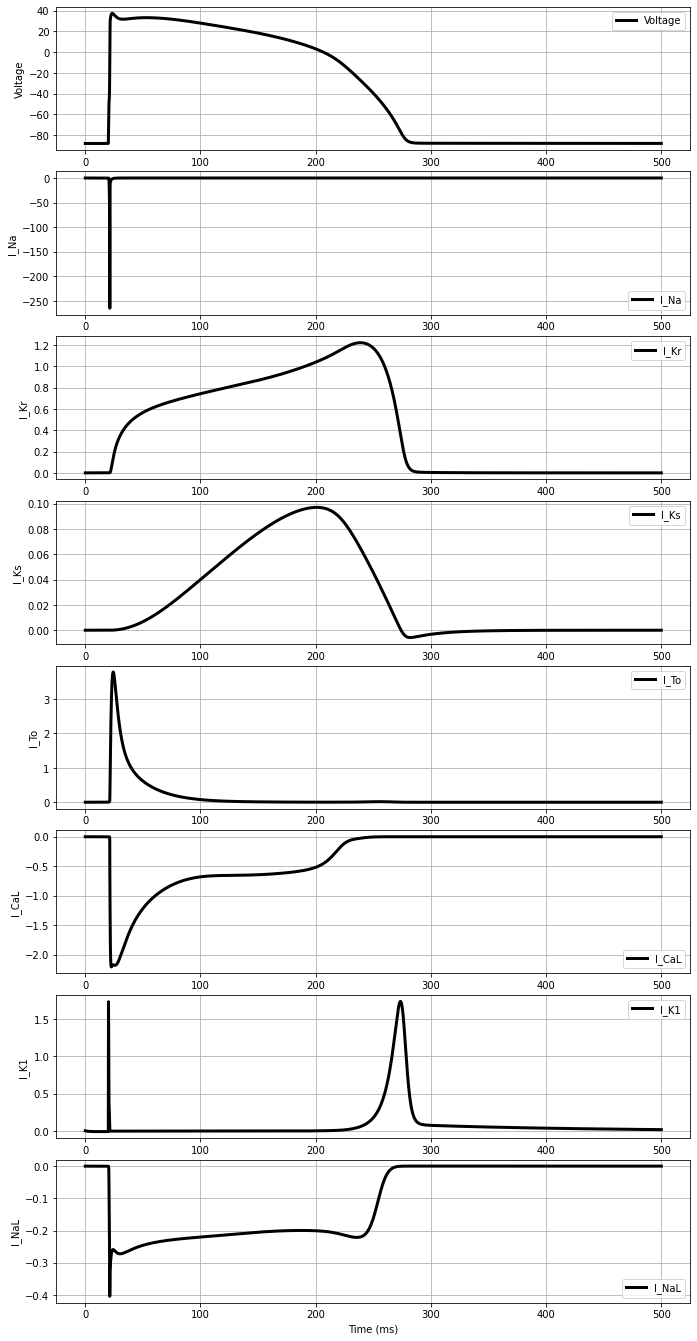

In [10]:
'''
Plot
'''
fig, ax = plt.subplots(8,1, figsize=(10,20))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times, values, label=name, color='k', linewidth=3)     
    ax[i].legend()
    ax[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "ORd2011_AP2.jpg"), dpi=100)

In [11]:
print("Complete")

Complete
